In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.compat.v2.feature_column as fc


print(tf.__version__)

2.11.0


<h4 style='color:lightblue'>Get data</h4>

In [2]:
df = pd.read_csv('insurance.csv')

df.shape

(1338, 7)

<h4 style='color:lightblue'>check data</h4>

In [3]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

<h4 style='color:lightblue'>adapt the data</h4>

In [4]:

df = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], prefix=['', 'smoker_', ''], prefix_sep='')
df.tail()

,age,bmi,children,expenses,female,male,smoker_no,smoker_yes,northeast,northwest,southeast,southwest
1333,50,31.0,3,10600.55,0,1,1,0,0,1,0,0
1334,18,31.9,0,2205.98,1,0,1,0,1,0,0,0
1335,18,36.9,0,1629.83,1,0,1,0,0,0,1,0
1336,21,25.8,0,2007.95,1,0,1,0,0,0,0,1
1337,61,29.1,0,29141.36,1,0,0,1,0,1,0,0


In [5]:
df.info

<bound method DataFrame.info of       age   bmi  children  expenses  female  male  smoker_no  smoker_yes  \
0      19  27.9         0  16884.92       1     0          0           1   
1      18  33.8         1   1725.55       0     1          1           0   
2      28  33.0         3   4449.46       0     1          1           0   
3      33  22.7         0  21984.47       0     1          1           0   
4      32  28.9         0   3866.86       0     1          1           0   
...   ...   ...       ...       ...     ...   ...        ...         ...   
1333   50  31.0         3  10600.55       0     1          1           0   
1334   18  31.9         0   2205.98       1     0          1           0   
1335   18  36.9         0   1629.83       1     0          1           0   
1336   21  25.8         0   2007.95       1     0          1           0   
1337   61  29.1         0  29141.36       1     0          0           1   

      northeast  northwest  southeast  southwest  
0   

<h4 style='color:lightblue'>Split data into testing and training datasets</h4>

In [6]:
# sample 20% of the dataframe for training purposes
train_dataset = df.sample(frac=0.8, random_state=0)

# the remaining 80% of the dataframe can be used for testing/validation
test_dataset = df.drop(train_dataset.index)

In [7]:
train_dataset.info

<bound method DataFrame.info of       age   bmi  children  expenses  female  male  smoker_no  smoker_yes  \
578    52  30.2         1   9724.53       0     1          1           0   
610    47  29.4         1   8547.69       1     0          1           0   
569    48  40.6         2  45702.02       0     1          0           1   
1034   61  38.4         0  12950.07       0     1          1           0   
198    51  18.1         0   9644.25       1     0          1           0   
...   ...   ...       ...       ...     ...   ...        ...         ...   
584    19  20.7         0   1242.82       0     1          1           0   
147    51  37.7         1   9877.61       1     0          1           0   
160    42  26.6         0  21348.71       1     0          0           1   
750    37  26.4         0  19539.24       1     0          0           1   
859    57  28.1         0  10965.45       0     1          1           0   

      northeast  northwest  southeast  southwest  
578 

<h4 style='color:lightblue'>Inspect data</h4>

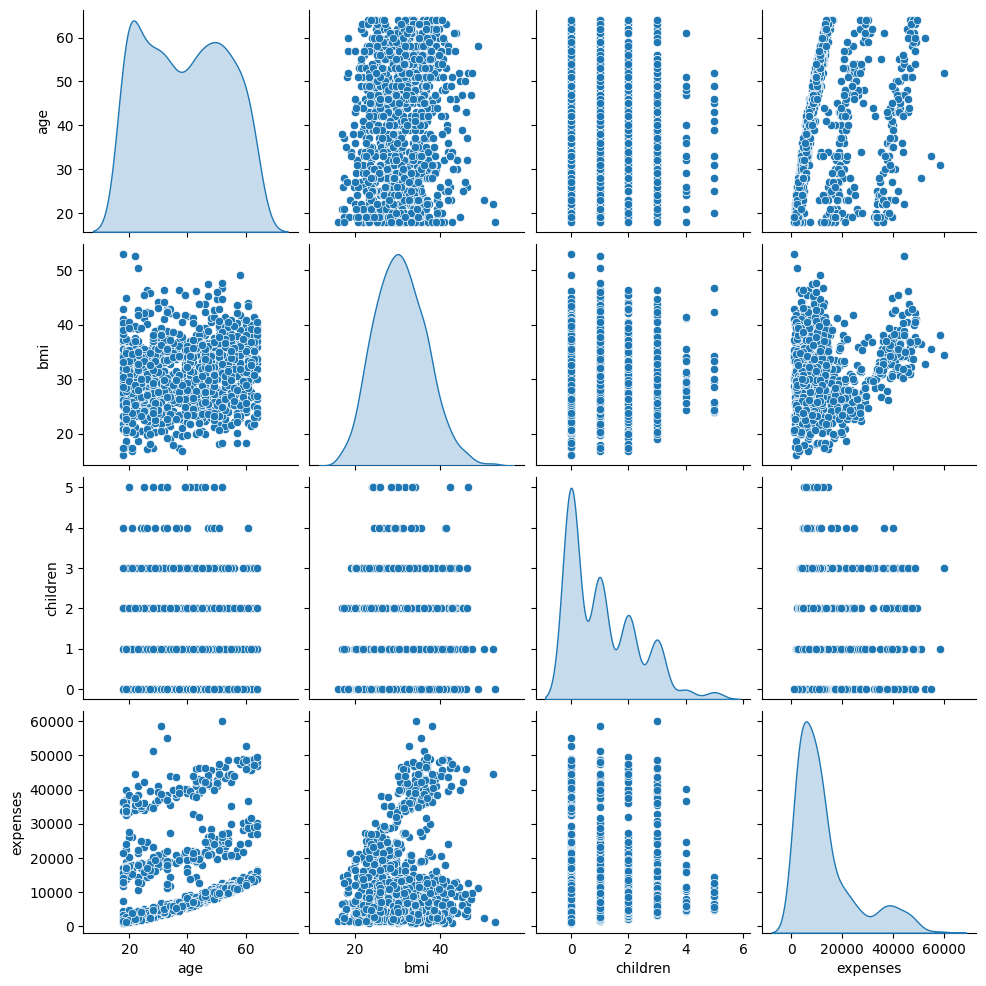

In [8]:

sns.pairplot(train_dataset[['age', 'bmi', 'children', 'expenses']], diag_kind='kde')

<AxesSubplot: >

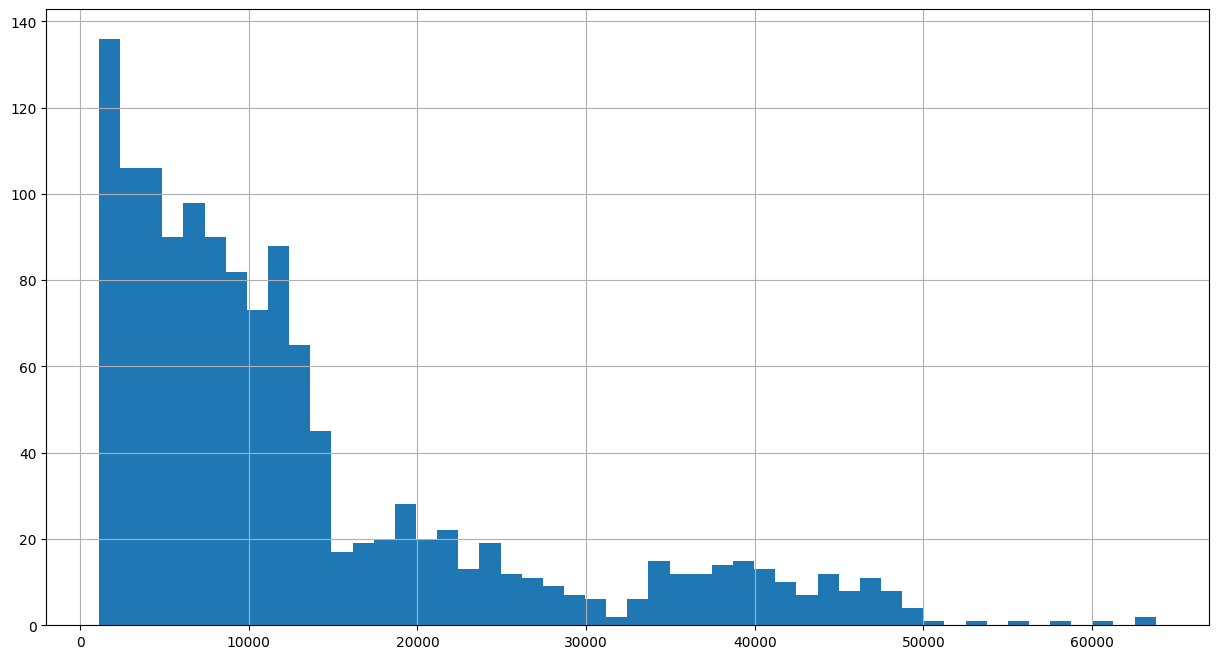

In [9]:
df.expenses.hist(bins=50, figsize=(15,8))

<h4 style='color:lightblue'>Pop labels off the dataset</h4>

In [10]:
train_labels = train_dataset.pop('expenses')
test_labels = test_dataset.pop('expenses')

<h4 style='color:lightblue'>Model creation</h4>

In [11]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [12]:
normalizer.adapt(np.array(train_dataset))

In [13]:
print(normalizer.mean.numpy())

[[39.036 30.737  1.093  0.502  0.498  0.801  0.199  0.249  0.236  0.281
   0.235]]


<h4 style='color:lightblue'>A function to see the models loss and val_loss converge</h4>

In [14]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [expenses]')
    plt.legend()
    plt.grid(True)

<h4 style='color:lightblue'>Build and compile model</h4>

In [15]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation = 'relu'),
        layers.Dense(64, activation = 'relu'),
        layers.Dense(1)
    ])
    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['mae', 'mse'])
    return model

In [16]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 11)               23        
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                768       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,016
Trainable params: 4,993
Non-trainable params: 23
_________________________________________________________________


In [17]:
history = dnn_model.fit(
    train_dataset,
    train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=120
)

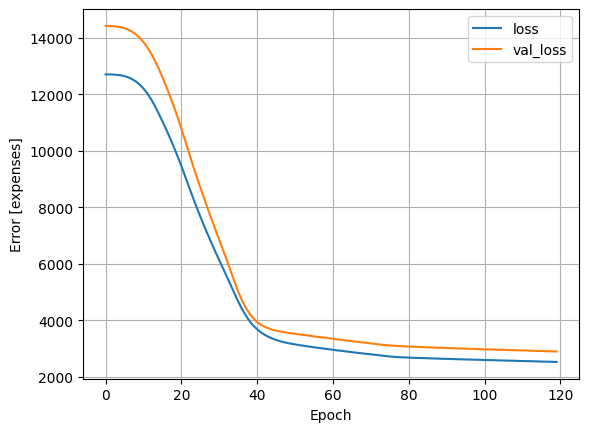

In [18]:
plot_loss(history)

<h4 style='color:lightblue'>renaming variables for test</h4>

In [19]:
model = dnn_model
test_dataset.info

<bound method DataFrame.info of       age   bmi  children  female  male  smoker_no  smoker_yes  northeast  \
11     62  26.3         0       1     0          0           1          0   
23     34  31.9         1       1     0          0           1          1   
24     37  28.0         2       0     1          1           0          0   
25     59  27.7         3       1     0          1           0          0   
28     23  17.4         1       0     1          1           0          0   
...   ...   ...       ...     ...   ...        ...         ...        ...   
1305   24  27.7         0       1     0          1           0          0   
1315   18  28.3         1       0     1          1           0          1   
1318   35  39.7         4       0     1          1           0          1   
1326   42  32.9         0       1     0          1           0          1   
1333   50  31.0         3       0     1          1           0          0   

      northwest  southeast  southwest  
11 

9/9 - 0s - loss: 3486.4424 - mae: 3486.4424 - mse: 48406552.0000 - 42ms/epoch - 5ms/step
Testing set Mean Abs Error: 3486.44 expenses
You passed the challenge. Great job!
9/9 [==============================] - 0s 960us/step


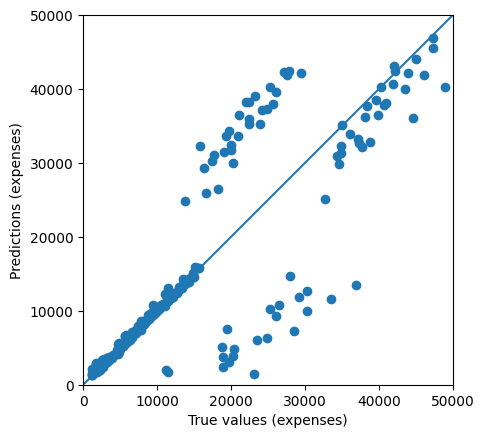

In [20]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
